# DIFUSIÓN DEL CORONAVIRUS EN ESPAÑA:

## (2ª predicción)

## 0. INTRODUCCIÓN

Si se quieren ver directamente los resultados de los cálculos, y el pronóstico para los próximos 5 días, pinchar <a href='#a1'>**--> aquí**</a>.

Este es un pequeño ejercicio de extrapolación para la curva de contagios del coronavirus en España.

Como fuente de los datos, a falta de una mejor, se toman los volcados en la siguiente página:

https://www.rtve.es/noticias/20200316/mapa-del-coronavirus-espana/2004681.shtml

Que recoge los datos que vuelca el Ministerio de Sanidad español. La hora de los contagios en el día de dicho informe puede variar, por lo que la diferencia entre un día y otro puede ser mayor o menor de 24 horas, pero a priori se asumirá que la hora del informe de todos los días es la misma, por falta de referencias.

En este script intentaremos predecir un intervalo para el final del crecimiento del número de contagios:

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

%matplotlib inline

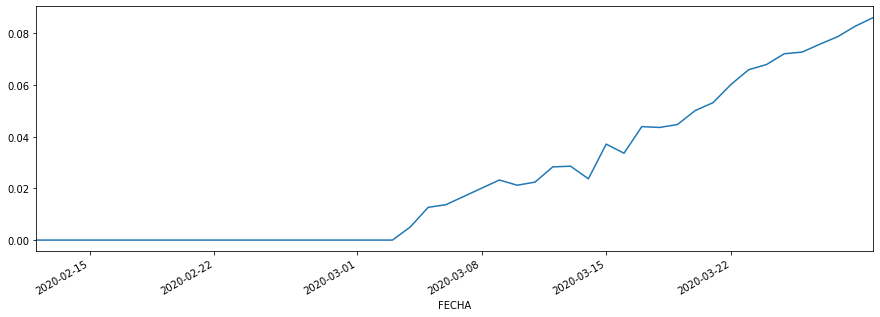

In [2]:
ruta = 'Datos/Contagios medios coronavirus RTVE.csv'
sep = ';'

date_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

datos = pd.read_csv(ruta, sep = sep, index_col = 'FECHA', parse_dates = ['FECHA'], date_parser = date_parser)

datos['DIFER_DIAS'] = datos.index.to_series().diff().fillna(pd.Timedelta(seconds = 8660000)).apply(lambda x: x.days)

datos['ratio'] = datos['MUERTOS']/datos['CONTAGIOS']
datos['ratio'].plot(figsize=(15,5));

In [3]:
contagios = datos[['DIFER_DIAS', 'CONTAGIOS']]
muertos = datos[['DIFER_DIAS', 'MUERTOS']]

## 1. CONTAGIOS

**Paso 1:**

**Comprobaciones sobre la serie:**

Examinamos primero los datos de los contagios:

In [4]:
# Sumamos 1 por cuestiones de estabilidad numérica a la hora de tomar logaritmos posteriormente:
contagios['DIFER'] = contagios['CONTAGIOS'].diff(1).fillna(2)/contagios['DIFER_DIAS']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
contagios['LN_CONTAGIOS'] = contagios['CONTAGIOS'].apply(lambda x: np.log(x) if x>0 else 0)
# Añadimos +1 por criterios de estabilidad con el logaritmo:
contagios['LN_DIFER'] = contagios['DIFER'].apply(lambda x: np.log(x+1) if x>0 else 0)
contagios['LN_DIFER_2']  = contagios['LN_DIFER'].diff(1).fillna(0)/contagios['DIFER_DIAS']

In [6]:
contagios.drop(contagios.index[0], inplace = True)

Vamos ahora a aplicar de nuevo un modelo de regresión lineal para nuestra serie, primero calculando la recta que realmente siguen los logartimos, para luego deshacer los cambios.

Una vez tengamos nuestro modelo calcularemos el error que nos devuelve nuestro ajuste y haremos predicciones:

In [7]:
def cols_para_calculos(df: 'DataFrame', columna_or: 'string', dates_in_index = True):
    
    if dates_in_index:
        day_range = (df.index - df.index[0]).days
        df.loc[:,'FECHA'] = day_range
    else:
        df['FECHA'] =(df.index - df.index[0])

    df['PARA_CALCULOS'] = (df[columna_or]).apply(lambda x: -10 if x == 0 else np.log(x))
    df['LOG_FECHA_0'] = np.array(np.log(df['FECHA']))
    df['LOG_FECHA_1'] = np.array(df['FECHA'].shift(1).apply(lambda x: 0 if (x == 0) else np.log(x)))

    df['DIF_FECHA'] = df['LOG_FECHA_0'] - df['LOG_FECHA_1']
    df['RATIO'] = df['PARA_CALCULOS'].diff()/df['DIF_FECHA']

    factor = df.loc[df.index[2]:,'RATIO'].mean()
    
    df['RECTA'] = df[columna_or]**(1/factor)
    
    return df, factor

In [8]:
df_contagios_pred = contagios[['CONTAGIOS', 'DIFER_DIAS', 'LN_CONTAGIOS']].copy()

df_contagios_pred, factor = cols_para_calculos(df_contagios_pred, 'LN_CONTAGIOS')
factor

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


0.4882135758626684

In [9]:
def ajuste_min_cuadrados(serie_x: 'Series', serie_y: 'Series', factor: 'float', col: 'string'):
    
    
    # Añadimos en el polyfit unos pesos exponenciales sobre el factor de corrección, 
    # para que el modelo ajuste el peso de los errores según los que tendrían con la distribución original 
    # del valor en y, y no la propia recta:
    
    x_range = serie_x
    coefs = np.polyfit(np.array(x_range), np.array(serie_y) , deg = 2, w=np.exp(serie_y**factor))

    arr_pred = x_range**2 * coefs[0] + x_range * coefs[1] + coefs[2]

    df_pred = pd.DataFrame(arr_pred)
    df_pred.rename({'FECHA':'PRED'}, axis=1, inplace = True)
    df_pred['RECTA'] = serie_y
    
    
    df_pred.plot(figsize=(18,5))
    print(df_pred.corr())
    
    df_pred[col] = np.round(np.exp(df_pred['PRED']**factor).fillna(1))

    return df_pred, coefs

           PRED     RECTA
PRED   1.000000  0.998374
RECTA  0.998374  1.000000


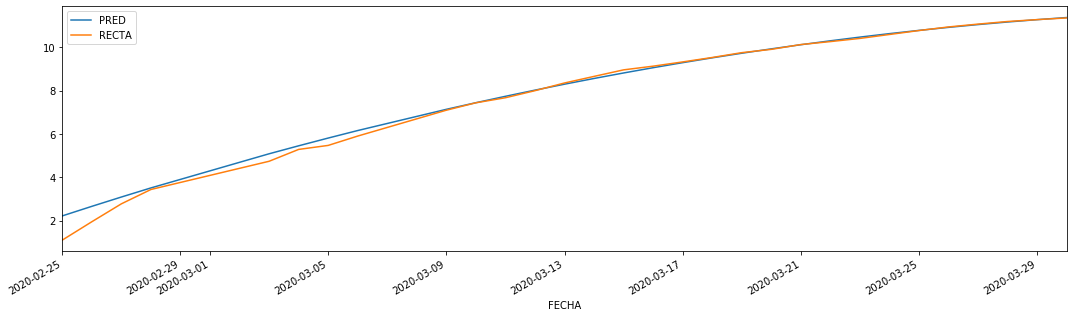

In [10]:
new_contagios_prediction, coefs = ajuste_min_cuadrados(df_contagios_pred['FECHA'], df_contagios_pred['LN_CONTAGIOS'], 1, 'PRED_CONTAGIOS')

In [11]:
df_contagios_pred['PRED_CONTAGIOS'] = new_contagios_prediction['PRED_CONTAGIOS']
df_contagios_pred['ERROR_ABS'] = abs(df_contagios_pred['PRED_CONTAGIOS'] - df_contagios_pred['CONTAGIOS'])
df_contagios_pred['ERROR_REL'] = (abs(df_contagios_pred['PRED_CONTAGIOS'] - df_contagios_pred['CONTAGIOS'])/df_contagios_pred['CONTAGIOS']).fillna(0)
df_contagios_pred.loc[df_contagios_pred.index[1]:,'ERROR_REL'].mean()

0.12251758300597576

In [12]:
df_contagios_pred.head()

,CONTAGIOS,DIFER_DIAS,LN_CONTAGIOS,FECHA,PARA_CALCULOS,LOG_FECHA_0,LOG_FECHA_1,DIF_FECHA,RATIO,RECTA,PRED_CONTAGIOS,ERROR_ABS,ERROR_REL
FECHA,,,,,,,,,,,,,
2020-02-25,3,13,1.098612,0,0.094048,-inf,NaN,NaN,NaN,1.212442,9.0,6.0,2.000000
2020-02-26,7,1,1.945910,1,0.665730,0.000000,0.000000,0.000000,inf,3.910259,14.0,7.0,1.000000
2020-02-27,16,1,2.772589,2,1.019781,0.693147,0.000000,0.693147,0.510789,8.075234,22.0,6.0,0.375000
2020-02-28,31,1,3.433987,3,1.233722,1.098612,0.693147,0.405465,0.527642,12.516064,33.0,2.0,0.064516
2020-03-03,114,4,4.736198,7,1.555235,1.945910,1.098612,0.847298,0.379457,24.180883,161.0,47.0,0.412281


Como se puede observar, el ajuste es malo para las fechas iniciales, pero mejor según nos acercamos a las actuales, presentando un error medio demasiado elevado.

Sin embargo, esa distribución del error no es uniforme.

Podemos ver que el error cometido del 15 de marzo en adelante es:

In [13]:
df_contagios_pred.loc[pd.to_datetime('2020-03-15'):,'ERROR_REL'].mean()

0.03358470585450067

... un 3,3%, lo cual es muy buen valor.

In [14]:
def prediccion(day_num_of_reference, date_of_reference, coeficientes, factor):    

    x_range_ext = np.array(range(day_num_of_reference + 1, day_num_of_reference + 6))
    index = [date_of_reference + datetime.timedelta(int(x)) for x in x_range_ext]
    arr_pred = x_range_ext**2 * coeficientes[0] +x_range_ext * coeficientes[1] + coeficientes[2]

    arr_pred = np.round(np.exp(arr_pred**factor))
    arr_pred = pd.DataFrame(arr_pred, columns = ['PRED'], index = index)
    return arr_pred

In [15]:
day_num_of_reference = df_contagios_pred['FECHA'][-1]
date_of_reference = df_contagios_pred.index[0]
arr_contagios_pred = prediccion(day_num_of_reference, date_of_reference, coefs, 1)
arr_contagios_pred

,PRED
2020-03-31,94708.0
2020-04-01,102301.0
2020-04-02,109362.0
2020-04-03,115702.0
2020-04-04,121144.0


Provisionalmente aceptaremos estos datos como resultantes de una primera iteración.

Sin embargo, podemos observar que extrapolar con los datos de contagios es complicado, en parte, debido a los cambios de criterio mencionados anteriormente.

## 2. MUERTOS

Pasamos ahora a comprobar los de los muertos:

In [16]:
muertos['MUERTOS_DIARIOS'] = muertos['MUERTOS'].diff().fillna(0)/muertos['DIFER_DIAS']
muertos['LN_MUERTOS'] = muertos['MUERTOS'].apply(lambda x: 0 if x == 0 else np.log(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
date_list = [muertos.index[-1] + datetime.timedelta(days=x+1) for x in range(10)]

,PRED,REAL
PRED,1.00000,0.99804
REAL,0.99804,1.00000


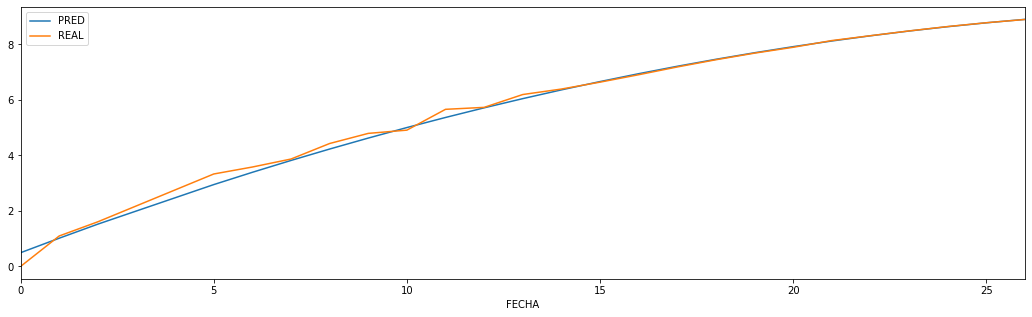

In [18]:
muertos_pol = muertos[muertos['MUERTOS'] != 0]
day_range = (muertos_pol.index - muertos[muertos['MUERTOS']>0].index[0]).days

coefs = np.polyfit(day_range, np.array(muertos_pol['LN_MUERTOS']) , 2, w=np.exp(np.array(muertos_pol['LN_MUERTOS'])))

arr_muertos_pred = day_range**2 * coefs[0] + day_range * coefs[1] + coefs[2]
    
df_muertos_pred = pd.DataFrame(arr_muertos_pred, index = day_range)
df_muertos_pred.rename({'FECHA':'PRED'}, axis=1, inplace = True)
df_muertos_pred['REAL'] = muertos_pol.set_index(day_range)['LN_MUERTOS']
df_muertos_pred.plot(figsize=(18,5));
df_muertos_pred.corr()

In [19]:
df_muertos_pred.drop('PRED', axis = 1, inplace = True)

In [20]:
df_muertos_pred, factor = cols_para_calculos(df_muertos_pred, 'REAL', dates_in_index = False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


          PRED    RECTA
PRED   1.00000  0.99804
RECTA  0.99804  1.00000


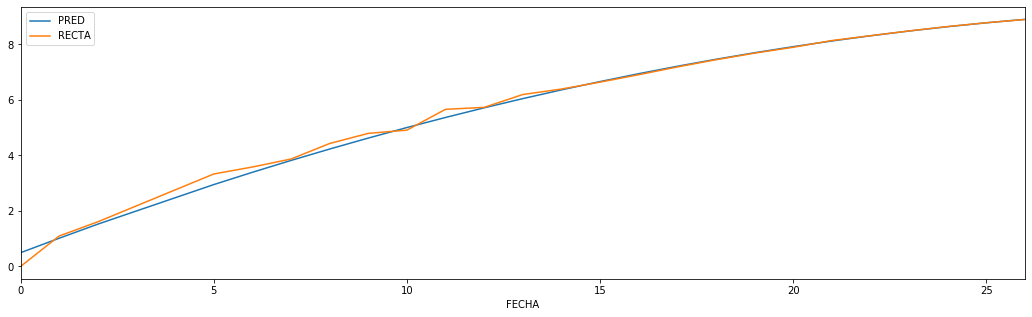

In [21]:
muertos_pol = muertos[muertos['MUERTOS'] != 0]

other_prediction, coefs = ajuste_min_cuadrados(df_muertos_pred['FECHA'], df_muertos_pred['REAL'], 1, 'PRED_MUERTES')

Ahora que ya tenemos las predicciones, deshacemos:

In [22]:
other_prediction['FECHA'] = muertos[muertos['MUERTOS'] != 0].index
other_prediction.set_index('FECHA', inplace = True)

Y, finalmente, tendremos ya el método ajustado y podemos insertarlo en nuestro DataFrame y calcular errores:

In [23]:
muertos['PRED'] = other_prediction['PRED_MUERTES']
muertos['PRED'].fillna(0, inplace = True)
muertos['ERROR_ABS'] = abs(muertos['PRED'] - muertos['MUERTOS'])
muertos['ERROR_REL'] = (abs(muertos['PRED'] - muertos['MUERTOS'])/muertos['MUERTOS']).fillna(0)
muertos.tail(10)

,DIFER_DIAS,MUERTOS,MUERTOS_DIARIOS,LN_MUERTOS,PRED,ERROR_ABS,ERROR_REL
FECHA,,,,,,,
2020-03-21,1,1326,324.0,7.189922,1359.0,33.0,0.024887
2020-03-22,1,1720,394.0,7.450080,1748.0,28.0,0.016279
2020-03-23,1,2182,462.0,7.687997,2213.0,31.0,0.014207
2020-03-24,1,2696,514.0,7.899524,2757.0,61.0,0.022626
2020-03-25,1,3434,738.0,8.141481,3380.0,54.0,0.015725
2020-03-26,1,4089,655.0,8.316056,4079.0,10.0,0.002446
2020-03-27,1,4858,769.0,8.488382,4844.0,14.0,0.002882
2020-03-28,1,5690,832.0,8.646466,5662.0,28.0,0.004921
2020-03-29,1,6528,838.0,8.783856,6513.0,15.0,0.002298


Como podemos ver, en este caso el ajuste es muy bueno. Vamos a extrapolar hacia el futuro, para predecir el total de muertos a lo largo de los próximos 5 días:

In [24]:
day_num_of_reference = df_muertos_pred.index[-1]
date_of_reference = muertos[muertos['MUERTOS'] != 0].index[0]

arr_muertos_pred = prediccion(day_num_of_reference, date_of_reference, coefs, 1)
arr_muertos_pred

,PRED
2020-03-31,8216.0
2020-04-01,9010.0
2020-04-02,9723.0
2020-04-03,10327.0
2020-04-04,10795.0


Y, una vez teniendo ya la predicción de los muertos totales, podemos añadir al DataFrame y calcular también la diferencia diaria:

Resaltar que, para el primer valor predicho de muertos diarios, el número puede estar ligeramente sobreestimado por la diferencia de 65 personas existente entre la predicción y el número real de muertos para la fecha del día de hoy (22/03/2020).

El resto de valores sí deberían estar en la línea del comportamiento futuro.

Como se puede ver, la evolución es ciertamente preocupante:

In [25]:
muertos = muertos.append(arr_muertos_pred, sort = False)
muertos.loc[muertos['MUERTOS_DIARIOS'].isna(), 'MUERTOS_DIARIOS'] = muertos.loc[muertos['MUERTOS_DIARIOS'].isna(), 'PRED'].diff()
missing_date = muertos[muertos['MUERTOS_DIARIOS'].isna()].index
muertos.loc[muertos['MUERTOS_DIARIOS'].isna(), 'MUERTOS_DIARIOS'] = muertos.loc[missing_date, 'PRED'] - muertos['MUERTOS'].shift(1)[missing_date]
muertos.tail(10)

,DIFER_DIAS,MUERTOS,MUERTOS_DIARIOS,LN_MUERTOS,PRED,ERROR_ABS,ERROR_REL
2020-03-26,1.0,4089.0,655.0,8.316056,4079.0,10.0,0.002446
2020-03-27,1.0,4858.0,769.0,8.488382,4844.0,14.0,0.002882
2020-03-28,1.0,5690.0,832.0,8.646466,5662.0,28.0,0.004921
2020-03-29,1.0,6528.0,838.0,8.783856,6513.0,15.0,0.002298
2020-03-30,1.0,7340.0,812.0,8.901094,7374.0,34.0,0.004632
2020-03-31,NaN,NaN,876.0,NaN,8216.0,NaN,NaN
2020-04-01,NaN,NaN,794.0,NaN,9010.0,NaN,NaN
2020-04-02,NaN,NaN,713.0,NaN,9723.0,NaN,NaN
2020-04-03,NaN,NaN,604.0,NaN,10327.0,NaN,NaN
2020-04-04,NaN,NaN,468.0,NaN,10795.0,NaN,NaN


Finalmente, dejamos el error relativo medio:

In [26]:
muertos.loc[date_of_reference + datetime.timedelta(int(day_num_of_reference-10)):, 'ERROR_REL'].mean()

0.013529704915119355

Como podemos ver, el error relativo cometido en el ajuste en los últimos 10 días con datos es del 6,5%, lo que es un valor aceptable para una primera estimación y da bastante confianza para nuestras estimaciones.

## 3. PREDICCIONES<a id='a1'></a>

Presentamos finalmente las predicciones, de seguir presentando la expansión del virus el comportamiento actual:

**CONTAGIOS (total contagiados)**

In [27]:
arr_contagios_pred

,PRED
2020-03-31,94708.0
2020-04-01,102301.0
2020-04-02,109362.0
2020-04-03,115702.0
2020-04-04,121144.0


**MUERTOS (total muertos)**

In [28]:
arr_muertos_pred

,PRED
2020-03-31,8216.0
2020-04-01,9010.0
2020-04-02,9723.0
2020-04-03,10327.0
2020-04-04,10795.0
